<a href="https://colab.research.google.com/github/Bassalttt/RobustnessEvaluationOnIdsEvasionAttack/blob/main/adversrial_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0 = attack  
1 = normal

### Initialization

Connect to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import libraries

In [ ]:
!pip install tqdm

In [3]:
# import libraries
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tqdm import tqdm
import matplotlib.pyplot as plt

# importing cleverhans - an adversarial example library
# from cleverhans.attacks import SaliencyMapMethod
# from cleverhans.attacks_tf import jacobian_graph

# Libraries relevant to performance metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Importing the Keras libraries and packages
# from keras.models import Sequential
# from keras.layers import Dense
from keras.callbacks import EarlyStopping

Authors

In [4]:
__author__ = "Md. Ahsan Ayub"
__license__ = "GPL"
__credits__ = ["Ayub, Md. Ahsan", "Johnson, Will",
               "Siraj, Ambareen"]
__maintainer__ = "Md. Ahsan Ayub"
__email__ = "mayub42@students.tntech.edu"
__status__ = "Prototype"

### Models

In [5]:
# Generate a multilayer perceptron  model or ANN
def mlp_model(input_dim: int, y: np.ndarray):
    n_classes = len(np.unique(y))

    model = Sequential()
    model.add(Dense(units=round(input_dim/2),
                    activation='relu',
                    input_shape=(input_dim,)))
    model.add(Dense(units=round(input_dim/2), activation='relu'))

    if n_classes > 2:  # multiclass with integer labels
        model.add(Dense(units=n_classes, activation='softmax'))
        loss = 'sparse_categorical_crossentropy'  # y must be int labels 0..C-1
    else:  # binary
        model.add(Dense(units=1, activation='sigmoid'))
        loss = 'binary_crossentropy'  # y should be 0/1, float or int

    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    print(model.summary())

    return model

In [6]:
def mlp_model_train(X, Y, val_split, batch_size, epochs_count):
    # Callback to stop if validation loss does not decrease
    callbacks = [EarlyStopping(monitor='val_loss', patience=2)]

    # Fitting the ANN to the Training set
    history = model.fit(X, Y,
                   callbacks=callbacks,
                   validation_split=val_split,
                   batch_size = batch_size,
                   epochs = epochs_count,
                   shuffle=True)
    # model.fit(X_train, Y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_val, Y_val))


    print(history.history)
    print(model.summary())
    return history

In [7]:
# Evaluate the multilayer perceptron  model or ANN during test time
def mlp_model_eval(X, Y, history, flag):
    # Predicting the results given instances X
    # Y_pred = model.predict_classes(X)
    # Y_pred = (Y_pred > 0.5)
    Y_pred = (model.predict(X) > 0.5).astype("int32")

    # Breakdown of statistical measure based on classes
    print(classification_report(Y, Y_pred, digits=4))

    # Making the cufusion Matrix
    cm = confusion_matrix(Y, Y_pred)
    print("Confusion Matrix:\n", cm)
    labels = np.unique(np.concatenate([Y, Y_pred]))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    print("labels = ", disp.display_labels)  # labels actually used
    disp.plot(cmap='Blues')  # You can use other colormaps: 'Reds', 'Greens', etc.
    plt.show()
    print("Accuracy: ", accuracy_score(Y, Y_pred))

    if(len(np.unique(Y))) == 2:
        print("F1: ", f1_score(Y, Y_pred, average='binary'))
        print("Precison: ", precision_score(Y, Y_pred, average='binary'))
        print("Recall: ", recall_score(Y, Y_pred, average='binary'))
    else:
        f1_scores = f1_score(Y, Y_pred, average=None)
        print("F1: ", np.mean(f1_scores))
        precision_scores = precision_score(Y, Y_pred, average=None)
        print("Precison: ", np.mean(precision_scores))
        recall_scores = recall_score(Y, Y_pred, average=None)
        print("Recall: ", np.mean(recall_scores))

    # ------------ Print Accuracy over Epoch --------------------

    # Intilization of the figure
    myFig = plt.figure(figsize=[12,10])

    plt.plot(history.history['accuracy'], linestyle = ':',lw = 2, alpha=0.8, color = 'black')
    plt.plot(history.history['val_accuracy'], linestyle = '--',lw = 2, alpha=0.8, color = 'black')
    plt.title('Accuracy over Epoch', fontsize=20, weight='bold')
    plt.ylabel('Accuracy', fontsize=18, weight='bold')
    plt.xlabel('Epoch', fontsize=18, weight='bold')
    plt.legend(['Train', 'Validation'], loc='lower right', fontsize=14)
    plt.xticks(ticks=range(0, len(history.history['accuracy'])))

    plt.yticks(fontsize=16)
    plt.show()

    if(len(np.unique(Y))) == 2:
        if(flag == 1): #Regular
            fileName = 'ANN_Accuracy_over_Epoch_Binary_Classification_TRAbIDRegular.eps'
        else: #Adversarial
            fileName = 'ANN_Accuracy_over_Epoch_Binary_Classification_TRAbID_Adversarial.eps'
    else:
        if(flag == 1): #Regular
            fileName = 'ANN_Accuracy_over_Epoch_Multiclass_Classification_TRAbID_Regular.eps'
        else: #Adversarial
            fileName = 'ANN_Accuracy_over_Epoch_Multiclass_Classification_TRAbID_Adversarial.eps'

    # Saving the figure
    myFig.savefig(fileName, format='eps', dpi=1200)

    # ------------ Print Loss over Epoch --------------------

    # Clear figure
    plt.clf()
    myFig = plt.figure(figsize=[12,10])

    plt.plot(history.history['loss'], linestyle = ':',lw = 2, alpha=0.8, color = 'black')
    plt.plot(history.history['val_loss'], linestyle = '--',lw = 2, alpha=0.8, color = 'black')
    plt.title('Loss over Epoch', fontsize=20, weight='bold')
    plt.ylabel('Loss', fontsize=18, weight='bold')
    plt.xlabel('Epoch', fontsize=18, weight='bold')
    plt.legend(['Train', 'Validation'], loc='upper right', fontsize=14)
    plt.xticks(ticks=range(0, len(history.history['loss'])))

    plt.yticks(fontsize=16)
    plt.show()

    if(len(np.unique(Y))) == 2:
        if(flag == 1): #Regular
            fileName = 'ANN_Loss_over_Epoch_Binary_Classification_TRAbID_Regular.eps'
        else: #Adversarial
            fileName = 'ANN_Loss_over_Epoch_Binary_Classification_TRAbID_Adversarial.eps'
    else:
        if(flag == 1): #Regular
            fileName = 'ANN_Loss_over_Epoch_Multiclass_Classification_TRAbID_Regular.eps'
        else: #Adversarial
            fileName = 'ANN_Loss_over_Epoch_Multiclass_Classification_TRAbID_Adversarial.eps'

    # Saving the figure
    myFig.savefig(fileName, format='eps', dpi=1200)


    # ------------ ROC Curve --------------------

    # Clear figure
    plt.clf()
    myFig = plt.figure(figsize=[12,10])

    if len(np.unique(Y)) == 2:
        fpr, tpr, _ = roc_curve(Y_test, Y_pred)
        plt.plot(fpr, tpr, color='black',
                label=r'ROC (AUC = %0.3f)' % (auc(fpr, tpr)),
                lw=2, alpha=0.8)

        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate', fontsize=18, weight='bold')
        plt.ylabel('True Positive Rate', fontsize=18, weight='bold')
        plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=20, fontweight='bold')
        plt.legend(loc="lower right",fontsize=14)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.show()

        if(flag == 1): #Regular
            fileName = 'ANN_Binary_Classification_ROC_TRAbID_Regular.eps'
        else: #Adversarial
            fileName = 'ANN_Binary_Classification_ROC_TRAbID_Adversarial.eps'

        # Saving the figure
        myFig.savefig(fileName, format='eps', dpi=1200)

### File path

Yung-Lin

In [8]:
project_path = "/content/drive/MyDrive/2025-Fall/14795-AIAppInfoSec/"
trabID_dataset_path = os.path.join(project_path, "TRAbID2017_dataset.arff")
trabID_y_path = os.path.join(project_path, "TRAbID2017_dataset_Y_class.csv")
# cicids2017_path = os.path.join(project_path, "CICIDS2017_dataset.csv")
# cicids2017_improved_path = os.path.join(project_path, ".csv")

Annie

In [ ]:
project_path = "/content/drive/MyDrive/Secure AI Project/14795-AIAppInfoSec/" # your project path
trabID_dataset_path = os.path.join(project_path, "TRAbID2017_dataset.arff")
trabID_y_path = os.path.join(project_path, "TRAbID2017_dataset_Y_class.csv")
# cicids2017_path = os.path.join(project_path, "CICIDS2017_dataset.csv")

### Main

In [9]:
#importing the data set
# print(tf.executing_eagerly())
# ==== Data processing for CICIDS 2017 ====
'''dataset = pd.read_csv(cicids2017_path)
print(dataset.head())
print(dataset.shape)

# Some manual processing on the dataframe
dataset = dataset.dropna()
dataset = dataset.drop(['Flow_ID', '_Source_IP', '_Destination_IP', '_Timestamp'], axis = 1)
dataset['Flow_Bytes/s'] = dataset['Flow_Bytes/s'].astype(float)
dataset['_Flow_Packets/s'] = dataset['_Flow_Packets/s'].astype(float)

# Creating X and Y from the dataset
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(dataset['Label'])
Y_attack = le.transform(dataset['Label'])
print(list(le.classes_))
print(np.unique(Y_attack))
Y_class = dataset.iloc[:,-1].values
X = dataset.iloc[:,0:80].values
X = X.astype(int)'''

# ==== Data processing for TRAbID 2017 ====

from scipy.io import arff
data = arff.loadarff(trabID_dataset_path)
dataset = pd.DataFrame(data[0])
print(dataset.head())
print(dataset.shape)


# Creating X and Y from the dataset
X = dataset.iloc[:,0:43].values
Y_class = pd.read_csv(trabID_y_path)
Y_class = Y_class.iloc[:,:].values

# Performing scale data
scaler = MinMaxScaler().fit(X)
X_scaled = np.array(scaler.transform(X))

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_class, test_size = 0.2, random_state = 42, stratify=Y_class)

print("Data Processing has been performed.")

# Tensorflow  placeholder  variables
# X_placeholder = tf.compat.v1.placeholder(tf.float32 , shape=(None , X_train.shape[1]))
# Y_placeholder = tf.compat.v1.placeholder(tf.float32 , shape=(None))

# tf.compat.v1.set_random_seed(42)
# model = mlp_model(X_train, Y_train)
# sess = tf.compat.v1.Session()
# init = tf.compat.v1.global_variables_initializer()
# sess.run(init)
tf.random.set_seed(42)
model = mlp_model(X_train.shape[1], Y_train)

predictions = model(X_test)
print('Prediction: ', predictions)

     ip_len     ip_id  ip_DF  ip_proto  ip_checksum  udp_sport  udp_dport  \
0 -0.991781  0.725856   -1.0    -0.375    -0.614487       -1.0       -1.0   
1 -0.983562 -0.903838    1.0    -0.375     0.345024       -1.0       -1.0   
2 -0.991781 -0.331533   -1.0    -0.375     0.458724       -1.0       -1.0   
3 -0.983562 -0.232197    1.0    -0.375    -0.325794       -1.0       -1.0   
4 -0.991781 -0.279805   -1.0    -0.375     0.336630       -1.0       -1.0   

   udp_len  udp_chk  icmp_type  ...  num_fin_dst_src  num_ack_src_dst  \
0     -1.0     -1.0       -1.0  ...        -1.000000        -1.000000   
1     -1.0     -1.0       -1.0  ...        -0.999954        -0.983809   
2     -1.0     -1.0       -1.0  ...        -1.000000        -0.999970   
3     -1.0     -1.0       -1.0  ...        -0.999969        -0.977915   
4     -1.0     -1.0       -1.0  ...        -1.000000        -0.999970   

   num_ack_dst_src  num_syn_src_dst  num_syn_dst_src  num_rst_src_dst  \
0        -0.999879       

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 22)             │           968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 22)             │           506 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            23 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,497 (5.85 KB)

 Trainable params: 1,497 (5.85 KB)

 Non-trainable params: 0 (0.00 B)

None
Prediction:  tf.Tensor(
[[0.45166972]
 [0.43916488]
 [0.4611173 ]
 ...
 [0.44901893]
 [0.41081923]
 [0.3970653 ]], shape=(3663, 1), dtype=float32)


X_train: 
 <class 'numpy.ndarray'> [[1.095900e-02 4.704205e-01 1.000000e+00 ... 4.800000e-05 0.000000e+00
  1.000000e+00]
 [1.095900e-02 8.662545e-01 1.000000e+00 ... 4.244500e-03 0.000000e+00
  1.000000e+00]
 [1.472600e-02 1.304495e-01 1.000000e+00 ... 0.000000e+00 0.000000e+00
  0.000000e+00]
 ...
 [1.794520e-01 8.447700e-01 0.000000e+00 ... 0.000000e+00 0.000000e+00
  0.000000e+00]
 [0.000000e+00 7.277945e-01 0.000000e+00 ... 2.400000e-05 0.000000e+00
  0.000000e+00]
 [8.219000e-03 7.155260e-01 1.000000e+00 ... 0.000000e+00 0.000000e+00
  0.000000e+00]]
Y_train: 
 <class 'numpy.ndarray'> [[1]
 [1]
 [0]
 ...
 [0]
 [1]
 [0]]
Epoch 1/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8570 - loss: 0.4590 - val_accuracy: 0.9945 - val_loss: 0.0428
Epoch 2/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9951 - loss: 0.0321 - val_accuracy: 0.9952 - val_loss: 0.0254
Epoch 3/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9960 - loss: 0.0194 - val_accuracy: 0.995

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 22)             │           968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 22)             │           506 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            23 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,493 (17.55 KB)

 Trainable params: 1,497 (5.85 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,996 (11.71 KB)

None
history keys:  dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
Performance when using actual testing instances
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0     0.9978    0.9973    0.9975      1832
           1     0.9973    0.9978    0.9975      1831

    accuracy                         0.9975      3663
   macro avg     0.9975    0.9975    0.9975      3663
weighted avg     0.9975    0.9975    0.9975      3663

Confusion Matrix:
 [[1827    5]
 [   4 1827]]
labels =  None


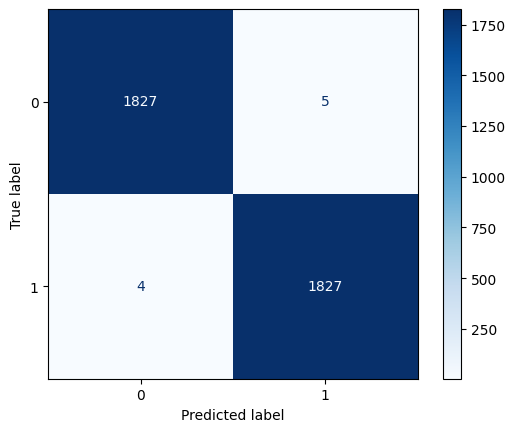

Accuracy:  0.9975429975429976
F1:  0.9975429975429976
Precison:  0.9972707423580786
Recall:  0.997815401419989


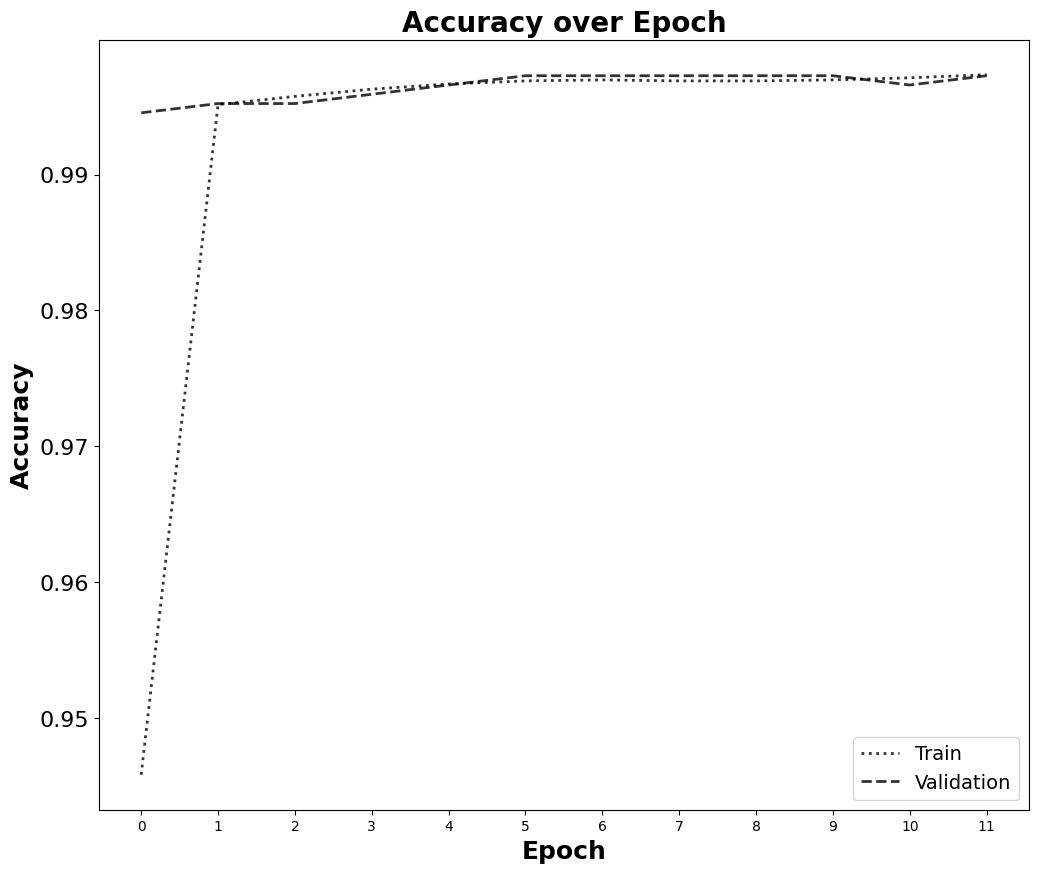

<Figure size 640x480 with 0 Axes>

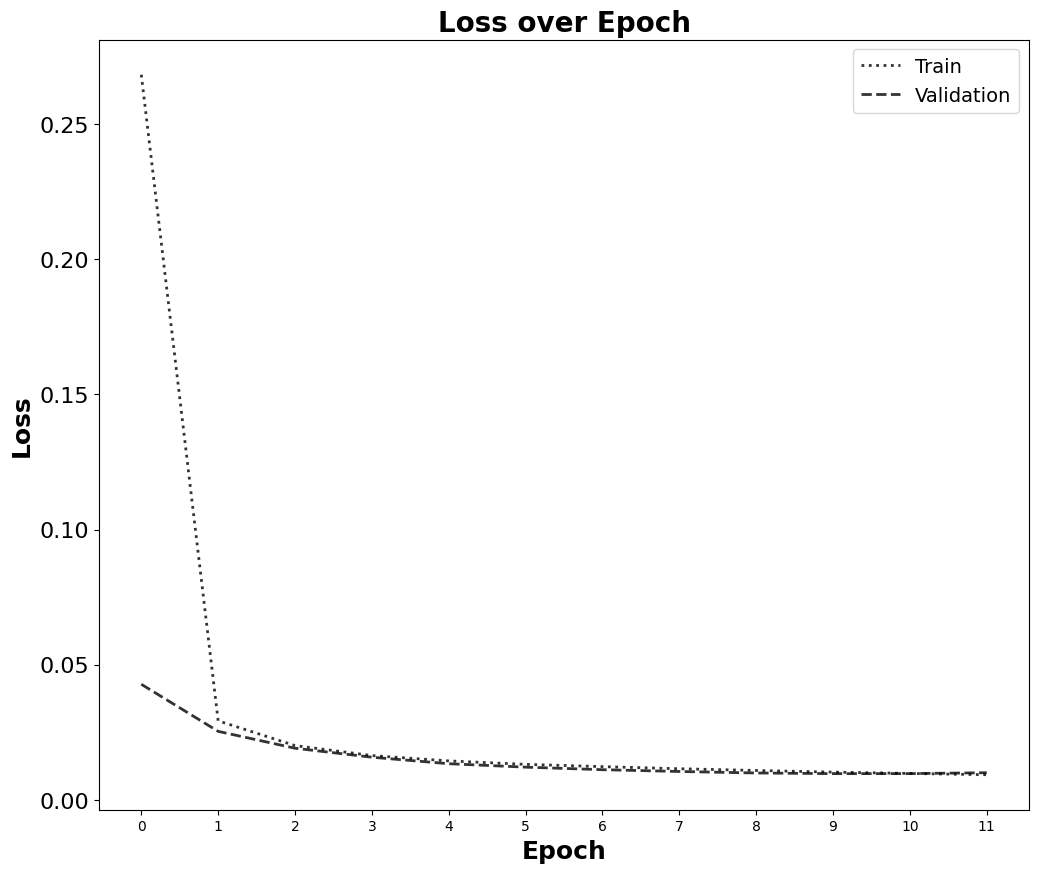

<Figure size 640x480 with 0 Axes>

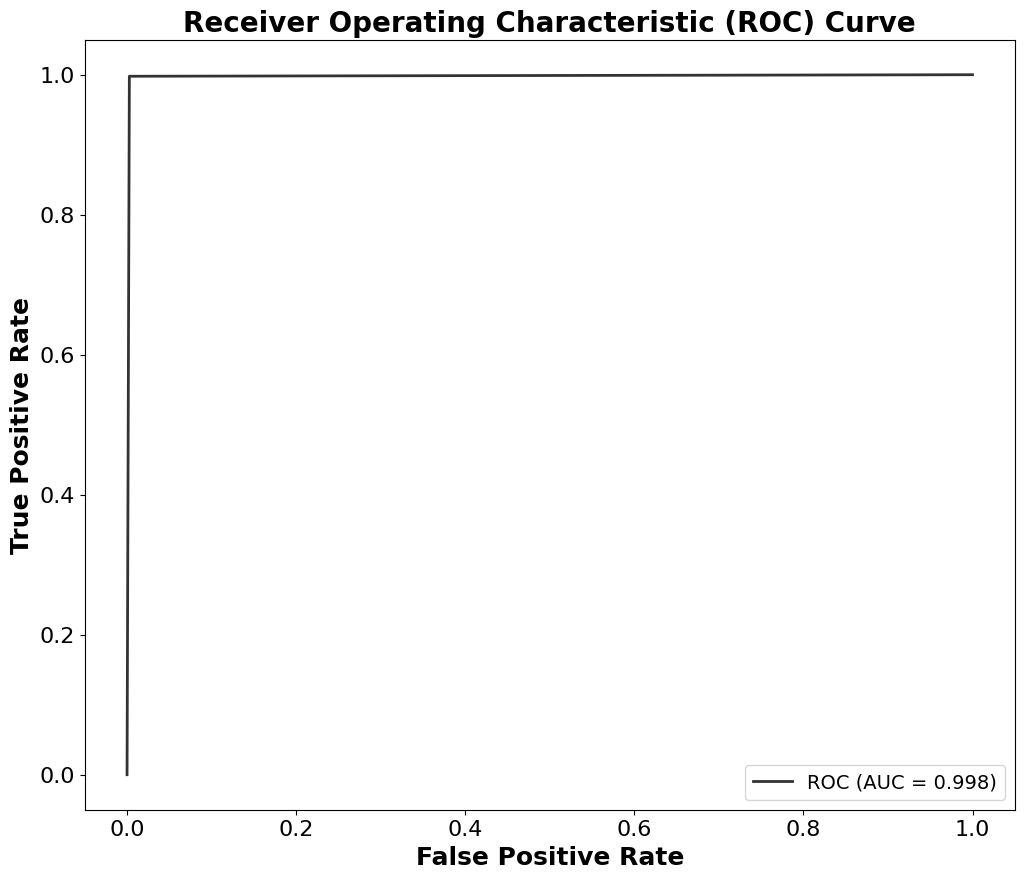

In [10]:
# ============== Training the model ==============
print("X_train: \n", type(X_train), X_train)
print("Y_train: \n", type(Y_train), Y_train)
history = mlp_model_train(X_train, Y_train,
                0.1, # Validation Split
                64, # Batch Size
                100 # Epoch Count
                )

print("history keys: ", history.history.keys())
# ============== Evaluation of the model with actual instances ==============

print("Performance when using actual testing instances")
mlp_model_eval(X_test, Y_test, history, 1)

### For Annie: JSMA

In [11]:
!pip install adversarial-robustness-toolbox

In [12]:
from art.attacks.evasion import SaliencyMapMethod
from art.estimators.classification import KerasClassifier

In [31]:
# --- Parameters (adjust as needed) ---
clip_min, clip_max = 0.0, 1.0
theta = 1        # step magnitude in original call
gamma = 0.1      # fraction of features to perturb
batch_size_attack = 1

# --- Build ART classifier from your Keras model ---
# model : a tf.keras.Model already compiled/trained
# n_classes: get from model output shape or from Y_test
if Y_test.ndim == 2:  # one-hot
    n_classes = Y_test.shape[1]
else:
    n_classes = int(np.max(Y_test) + 1)

# KerasClassifier is a thin wrapper; it only needs the Keras model and clip values
classifier = KerasClassifier(model=model, clip_values=(clip_min, clip_max), use_logits=False)

# --- Create the ART SaliencyMapMethod attack ---
# The attack uses theta and gamma, and we set targeted via passing y (target labels) to generate()
smm = SaliencyMapMethod(
    classifier=classifier,
    theta=theta,
    gamma=gamma,
    batch_size=batch_size_attack,
    verbose=False
)

# --- Prepare arrays for results ---
n_classes = int(classifier.nb_classes)   # expect 2 for binary
assert n_classes >= 2, "JSMA needs at least 2 classes."
assert n_classes == 2, "This loop targets binary (0/1); adjust for multiclass."

source_samples = X_test.shape[0]

results        = np.zeros((n_classes, source_samples), dtype=float)
perturbations  = np.zeros((n_classes, source_samples), dtype=float)
X_adv          = np.zeros_like(X_test, dtype=np.float32)

target = 1  # we want to move class 0 -> class 1

for sample_ind in tqdm(range(source_samples)):
    x_orig = X_test[sample_ind: sample_ind + 1].astype(np.float32)  # (1, features)

    # Ensure integer true label (supports int or one-hot)
    y_true = Y_test[sample_ind]
    current_class = int(np.argmax(y_true)) if isinstance(y_true, np.ndarray) and y_true.ndim > 0 else int(y_true)

    # Skip if already the target class
    if current_class == target:
        results[target, sample_ind] = 0.0
        perturbations[target, sample_ind] = 0.0
        X_adv[sample_ind] = x_orig
        continue

    # Safety: ensure current_class is in range
    if not (0 <= current_class < n_classes):
        raise ValueError(f"Label {current_class} not in [0, {n_classes-1}]")

    # One-hot target for ART (batch of 1)
    target_onehot = np.eye(n_classes, dtype=np.float32)[[target]]  # (1, 2)
    assert target_onehot.shape == (1, n_classes)

    # Generate adversarial example targeting class 1
    try:
        x_adv = smm.generate(x=x_orig, y=target_onehot)
    except Exception as e:
        print(f"Attack generation failed for sample {sample_ind}, target {target}: {e}")
        x_adv = x_orig.copy()

    # Store example
    X_adv[sample_ind] = x_adv[0]

    # Predict class on x_adv
    preds = model.predict(x_adv, verbose=0)
    # Normalize to 2D
    preds = preds if preds.ndim == 2 else preds.reshape((-1, 1))
    if preds.shape[1] == 1:
        pred_class = int((preds > 0.5).astype(int).ravel()[0])
    else:
        pred_class = int(np.argmax(preds, axis=1)[0])

    results[target, sample_ind] = float(pred_class == target)

    # Percent of features changed (L0 fraction * 100)
    tol = 1e-6
    changed = np.abs(x_adv - x_orig) > tol
    perturbations[target, sample_ind] = float(np.mean(changed)) * 100.0


  0%|          | 1/3663 [00:00<20:30,  2.98it/s]

Attack generation failed for sample 0, target 1: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 1 of dimension 1 out of bounds. [Op:StridedSlice] name: strided_slice/


  0%|          | 2/3663 [00:00<19:17,  3.16it/s]

Attack generation failed for sample 1, target 1: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 1 of dimension 1 out of bounds. [Op:StridedSlice] name: strided_slice/


  0%|          | 3/3663 [00:00<18:33,  3.29it/s]

Attack generation failed for sample 2, target 1: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 1 of dimension 1 out of bounds. [Op:StridedSlice] name: strided_slice/


  0%|          | 4/3663 [00:01<18:19,  3.33it/s]

Attack generation failed for sample 3, target 1: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 1 of dimension 1 out of bounds. [Op:StridedSlice] name: strided_slice/


  0%|          | 5/3663 [00:01<17:53,  3.41it/s]

Attack generation failed for sample 4, target 1: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 1 of dimension 1 out of bounds. [Op:StridedSlice] name: strided_slice/


  0%|          | 6/3663 [00:01<17:46,  3.43it/s]

Attack generation failed for sample 5, target 1: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 1 of dimension 1 out of bounds. [Op:StridedSlice] name: strided_slice/


  0%|          | 7/3663 [00:02<17:44,  3.44it/s]

Attack generation failed for sample 6, target 1: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 1 of dimension 1 out of bounds. [Op:StridedSlice] name: strided_slice/


  0%|          | 8/3663 [00:02<20:04,  3.03it/s]

Attack generation failed for sample 7, target 1: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 1 of dimension 1 out of bounds. [Op:StridedSlice] name: strided_slice/


  0%|          | 9/3663 [00:02<22:04,  2.76it/s]

Attack generation failed for sample 8, target 1: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 1 of dimension 1 out of bounds. [Op:StridedSlice] name: strided_slice/


  0%|          | 10/3663 [00:03<23:25,  2.60it/s]

Attack generation failed for sample 9, target 1: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 1 of dimension 1 out of bounds. [Op:StridedSlice] name: strided_slice/


  0%|          | 11/3663 [00:03<24:12,  2.51it/s]

Attack generation failed for sample 10, target 1: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 1 of dimension 1 out of bounds. [Op:StridedSlice] name: strided_slice/


  0%|          | 12/3663 [00:04<24:55,  2.44it/s]

Attack generation failed for sample 11, target 1: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 1 of dimension 1 out of bounds. [Op:StridedSlice] name: strided_slice/


  0%|          | 13/3663 [00:04<25:32,  2.38it/s]

Attack generation failed for sample 12, target 1: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 1 of dimension 1 out of bounds. [Op:StridedSlice] name: strided_slice/


  0%|          | 14/3663 [00:05<26:11,  2.32it/s]

Attack generation failed for sample 13, target 1: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 1 of dimension 1 out of bounds. [Op:StridedSlice] name: strided_slice/


  0%|          | 15/3663 [00:05<26:27,  2.30it/s]

Attack generation failed for sample 14, target 1: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 1 of dimension 1 out of bounds. [Op:StridedSlice] name: strided_slice/


  0%|          | 15/3663 [00:05<23:18,  2.61it/s]


KeyboardInterrupt: 

In [25]:
print(results, len(results[0]))
print(np.any(results == 1)) # all are zeros
preds = model.predict(X_adv[:10], verbose=0)
if preds.shape[-1] == 1:
    # binary-prob output
    pred_class = int((preds > 0.5).astype(int).ravel()[0])
else:
    pred_class = int(np.argmax(preds, axis=1)[0])
print(pred_class)

[[0. 0. 0. ... 0. 0. 0.]] 3663
False
1


Performance when using adversarial testing instances
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0     0.9978    0.9973    0.9975      1832
           1     0.9973    0.9978    0.9975      1831

    accuracy                         0.9975      3663
   macro avg     0.9975    0.9975    0.9975      3663
weighted avg     0.9975    0.9975    0.9975      3663

Confusion Matrix:
 [[1827    5]
 [   4 1827]]
labels =  None


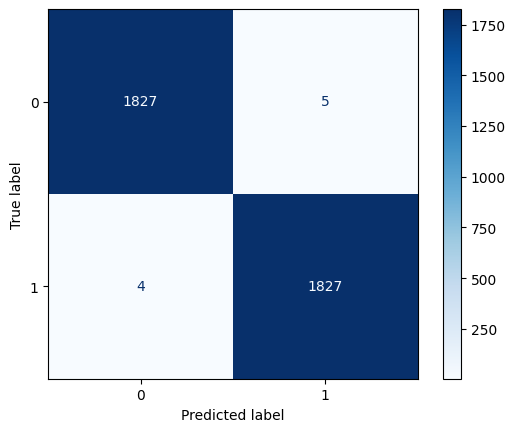

Accuracy:  0.9975429975429976
F1:  0.9975429975429976
Precison:  0.9972707423580786
Recall:  0.997815401419989


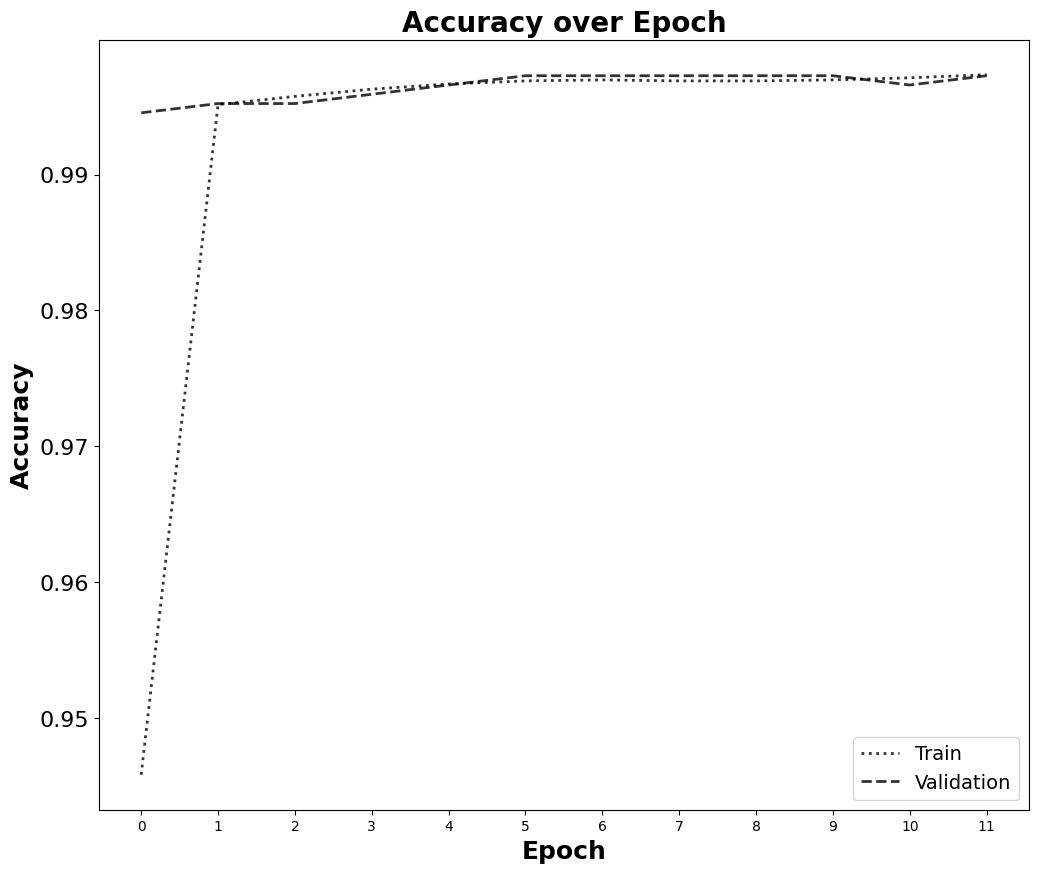

<Figure size 640x480 with 0 Axes>

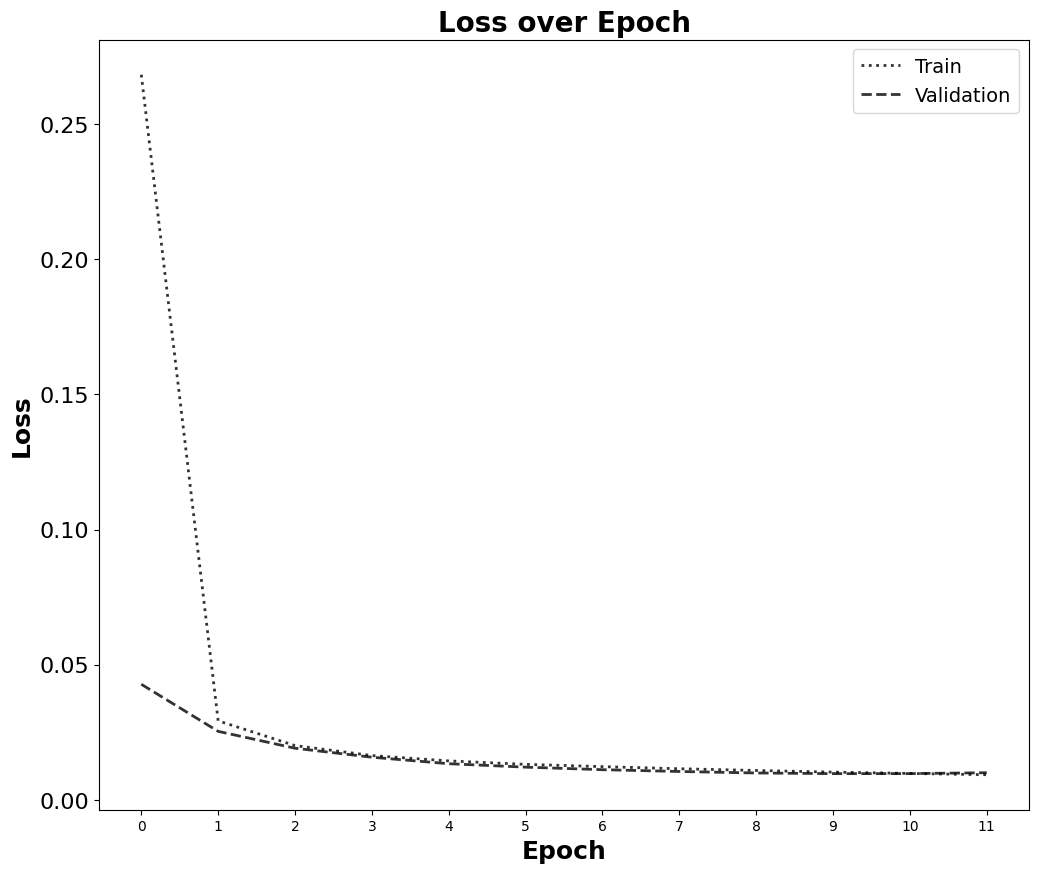

<Figure size 640x480 with 0 Axes>

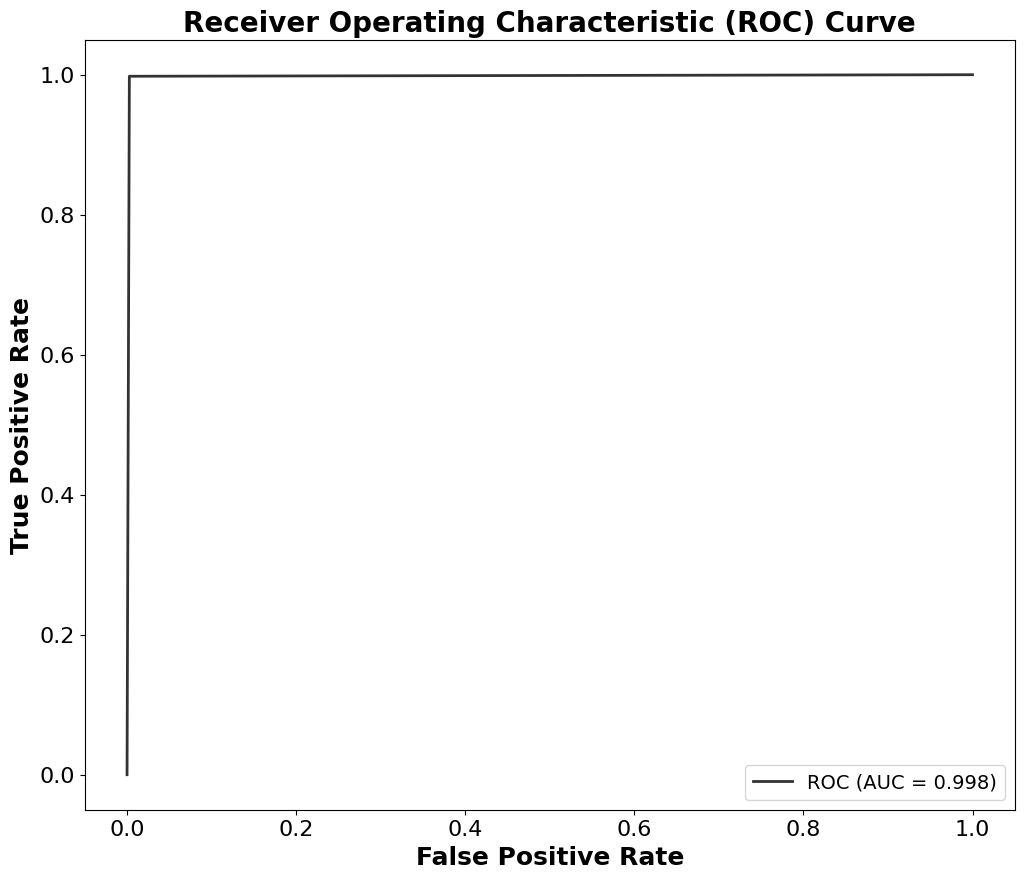

In [17]:
# ============== Evaluation of the model with adversarial instances ==============

print("Performance when using adversarial testing instances")
mlp_model_eval(X_adv, Y_test, history, 2)